Title & Description: 
Building A lightweight U-Net for brain tumor segmentation (using BraTS dataset) under limited GPU resources, and comparing performance (Dice score + qualitative results) to the BraTS 2020 nnU-Net winner (DKFZ_MIC).

Imports & Setup

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

# Processing Libs 
import skimage as ski
import PIL.Image as Image

# NN libs
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

# Neural Imaging Libs
import nibabel as nib
import nilearn.plotting as nlplt
import nilearn as nl

#Getting helper scripts
from utils.data_loader import BraTSDataset
from utils.data_loader import visualize_sample
from utils.data_loader import get_brats_filepaths
# from utils.unet import UNet
# from utils.metrics import dice_score, etc

In [2]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Paths
RAW_DATA_PATH = "data/raw/"
PROCESSED_DATA_PATH = "data/processed/"
MODELS_PATH = "models/"
RESULTS_PATH = "results/"


Using device: cuda


Loading and Visualizing sample data

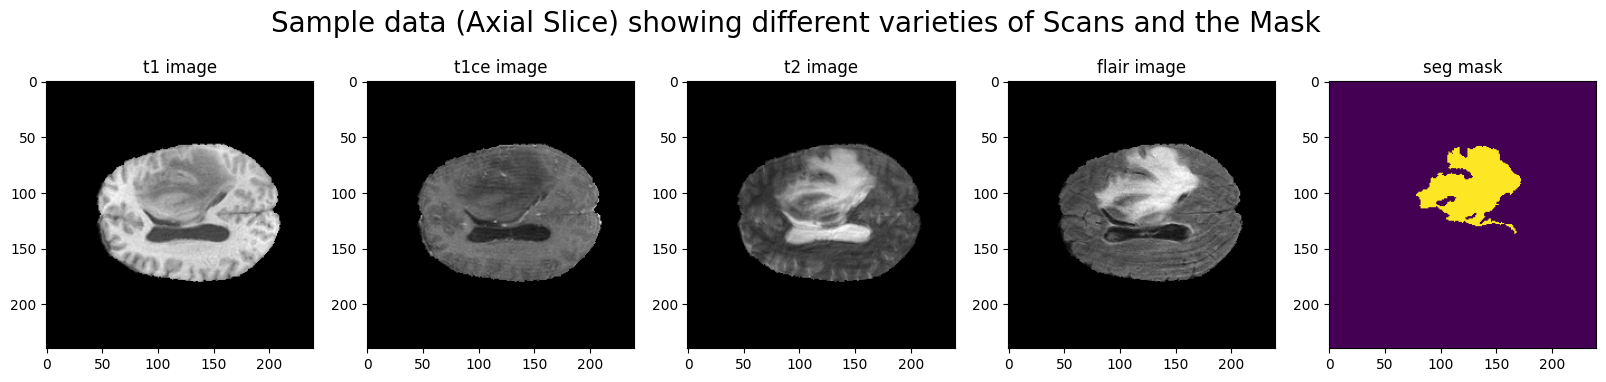

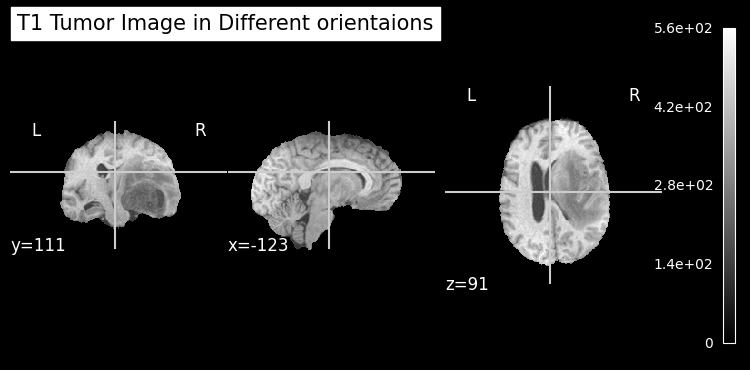

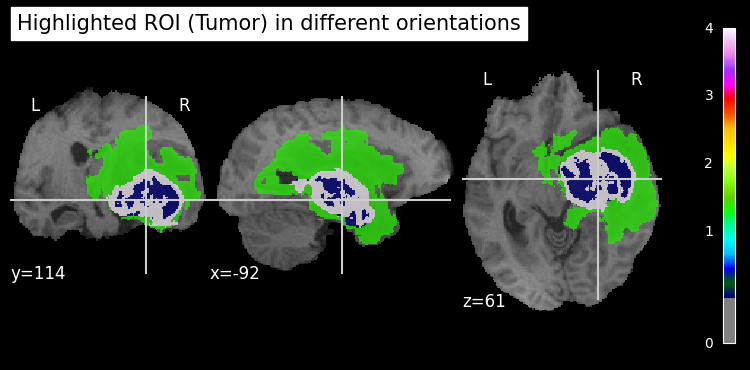

In [4]:
###
Test_filepath = "data/raw/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/"
# Loading data and extracting image data with "get_fdata()"
test_t1_image = nib.load(Test_filepath + "BraTS20_Training_001_t1.nii").get_fdata()
test_t1ce_image = nib.load(Test_filepath + "BraTS20_Training_001_t1ce.nii").get_fdata()
test_t2_image = nib.load(Test_filepath + "BraTS20_Training_001_t2.nii").get_fdata()
test_flair_image = nib.load(Test_filepath + "BraTS20_Training_001_flair.nii").get_fdata()
test_mask = nib.load(Test_filepath + "BraTS20_Training_001_seg.nii").get_fdata()

volume_show = 89 #Orientation to view 

# Visualizing sample of Image data
 
fig , (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize = (20, 10))

fig.suptitle('Sample data (Axial Slice) showing different varieties of Scans and the Mask'
            , y=0.70, fontsize=20 )

ax1.imshow(test_t1_image[:,:,volume_show], cmap = "gray")
ax1.set_title("t1 image")

ax2.imshow(test_t1ce_image[:,:,volume_show], cmap = "gray")
ax2.set_title("t1ce image")

ax3.imshow(test_t2_image[:,:,volume_show], cmap = "gray")
ax3.set_title("t2 image")

ax4.imshow(test_flair_image[:,:,volume_show], cmap = "gray")
ax4.set_title("flair image")

ax5.imshow(test_mask[:,:,volume_show])
ax5.set_title("seg mask")

nl_test_t1_image = nl.image.load_img(Test_filepath + "BraTS20_Training_001_t1.nii")
nl_test_mask_image = nl.image.load_img(Test_filepath + "BraTS20_Training_001_seg.nii")

nlplt.plot_epi(nl_test_t1_image, title="T1 Tumor Image in Different orientaions")
nlplt.plot_roi(nl_test_mask_image,bg_img=nl_test_t1_image , title="Highlighted ROI (Tumor) in different orientations")

In [7]:
trainingData_root_dir = os.path.join(
    RAW_DATA_PATH, 
    "BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
)

image_paths, mask_paths = get_brats_filepaths(trainingData_root_dir) ##Collecting image and mask file paths for our data loader 

# print("Number of patients:", len(image_paths))
# print(" ")
# print("Example modalities:", image_paths[0])
# print(" ")
# print("Example mask:", mask_paths[0])


Dataset Preprocessing

In [13]:
# Dataset
train_dataset = BraTSDataset(image_paths, mask_paths, 
                                  target_shape=(128,128,128), 
                                  patch_size=(96,96,96), 
                                  augment=True, 
                                  num_classes=4)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

# Fetch a batch
for img, mask in train_loader:
    print("Image shape:", img.shape)   # (B,4,96,96,96)  four MRI modalities
    print("Mask shape:", mask.shape)   # (B,4,96,96,96)  one-hot segmentation
    break


Image shape: torch.Size([2, 4, 96, 96, 96])
Mask shape: torch.Size([2, 4, 96, 96, 96])


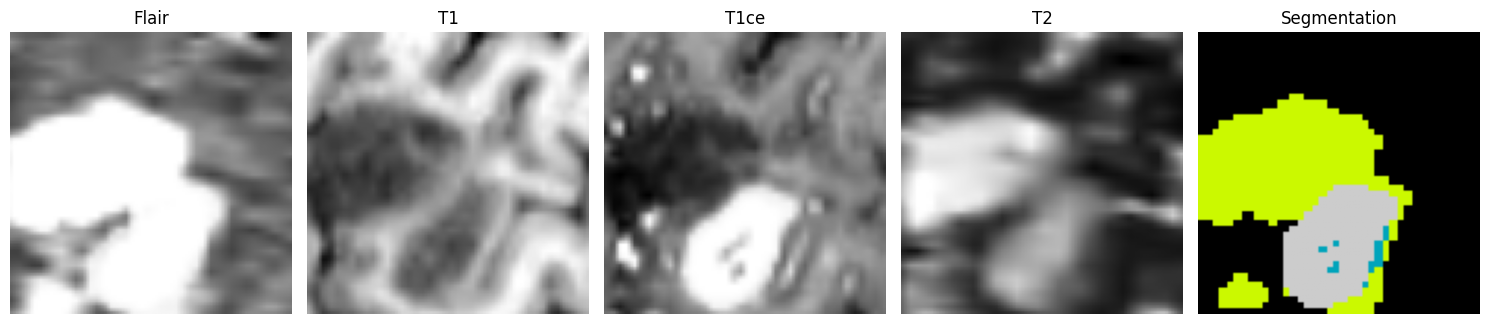

In [15]:
##Pipeline Visualization check
'''
Making sure data processing pipeline looks good (or actually doing what we need) , before training!
'''

# Get one batch
img_batch, mask_batch = next(iter(train_loader))

# Take the first sample in the batch
img_sample = img_batch[0]   # (4,D,H,W)
mask_sample = mask_batch[0] # (4,D,H,W)

# Visualize
visualize_sample(img_sample, mask_sample, slice_idx=34)

Baseline U-Net Setup

Training Loop (Baseline)

Evaluation (Baseline)

Optimized U-Net Setup

Training Loop (Optimized)

Evaluation (Optimized)

Comparison & Visualization

Conclusion